In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Synthetic data creation with the logistic equation



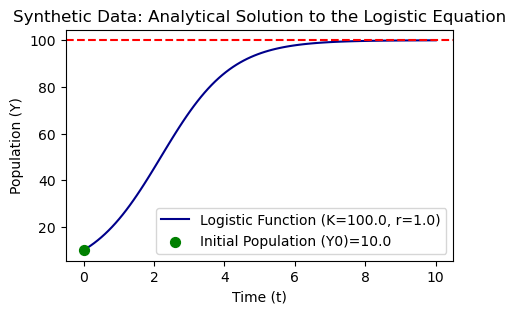

In [47]:
# --- Parameters ---
r = 1.0        # Growth Rate
K = 100.0      # Carrying Capacity
Y0 = 10.0      # Initial Population
t_min, t_max = 0.0, 10.0 # Time domain
N_POINTS = 100 # Number of time points to enforce physics
t0 = (1/r) * np.log(K / Y0 - 1) # Mid point value

# Generate data 
t = torch.linspace(t_min, t_max, N_POINTS, dtype=torch.float32).reshape(-1, 1).to(DEVICE)
t_np = t.cpu().numpy()

def analytical_logistic_solution(K, r, t0, t_array):
    return K / (1 + np.exp(-r * (t_array - t0)))

Y_ideal = analytical_logistic_solution(K, r, t0, t_np)

# Plot data
plt.figure(figsize=(5, 3))
plt.plot(t_np, Y_ideal, label=f'Logistic Function (K={K}, r={r})', color='darkblue', linewidth=1.5)
plt.axhline(y=K, color='r', linestyle='--')

initial_point = Y_ideal[0]
plt.scatter(t_min, initial_point, color='green', s=50, label=f'Initial Population (Y0)={Y0}', zorder=5)

plt.title('Synthetic Data: Analytical Solution to the Logistic Equation')
plt.xlabel('Time (t)')
plt.ylabel('Population (Y)')
# plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## Adding gaussian noise



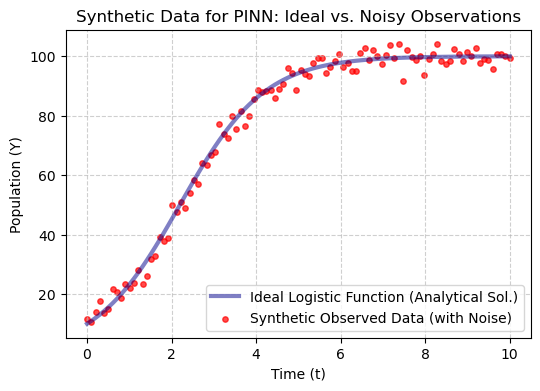

In [51]:
NOISE_STD = 3.0 # Standard deviation of the Gaussian noise
np.random.seed(42)
noise = np.random.normal(0, NOISE_STD, Y_ideal.shape)
Y_observed = Y_ideal + noise
plt.figure(figsize=(6, 4))
plt.plot(t_np, Y_ideal, label='Ideal Logistic Function (Analytical Sol.)', color='darkblue', linewidth=3, alpha=0.5)
plt.scatter(t_np, Y_observed, label='Synthetic Observed Data (with Noise)', color='red', s=15, alpha=0.7)
plt.title('Synthetic Data for PINN: Ideal vs. Noisy Observations')
plt.xlabel('Time (t)')
plt.ylabel('Population (Y)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [17]:
class PINN(nn.Module):
    def __init__(self, K=100.0):
        super().__init__() # calls the constructor of the parent class
        self.K = K
        
        self.il = nn.Linear(1, 20)
        
        self.hl1 = nn.Linear(20, 20) # Hidden layer 1
        self.hl2 = nn.Linear(20, 20) # Hidden layer 2
        
        self.ol = nn.Linear(20, 1) # Output layer
   
    def forward(self, x):
        out = torch.tanh(self.il(x))
        
        out = torch.tanh(self.hl1(out))
        
        out = torch.tanh(self.hl2(out))
        
        Z = torch.tanh(self.ol(out)) # tanh is between -1 and 1, our popluation is between 0 and K
        
        Y_pred = self.K / 2 * (1 + Z) # When Z is -1 we get 0, when it is 1 we get K
        
        return Y_pred

In [18]:
def physics_loss(t, model, r=1.0):
    t_physics = t.clone()
    t_physics.requires_grad = True
    
    Y_pred = model(t_physics)
    K = model.K
    
    # dY_dt using torch.autograd.grad
    dY_dt = torch.autograd.grad(
        inputs = t_physics, 
        outputs = Y_pred, 
        grad_outputs=torch.ones_like(Y_pred), 
        create_graph=True   # graph of the derivative will be constructed, allowing to compute higher order derivative products.
    )[0]
    
    # the residual (f) based on the DE:
    f =  dY_dt - (r * Y_pred * (1 - (Y_pred/K)))

    
    # MSE loss for the residual
    loss_f = torch.mean(f**2)
    
    return loss_f

In [21]:
def boundary_loss(model, Y0=10.0):
    t_bc = torch.tensor([0.0]).reshape(-1, 1) .to(DEVICE)
    
    Y_pred_bc = model(t_bc) 
    
    Y_actual_bc = torch.tensor([Y0]).reshape(-1, 1).to(DEVICE)
    
    loss_bc = torch.mean((Y_pred_bc - Y_actual_bc)**2)
    
    return loss_bc

In [23]:
# --- Initialize Model and Optimizer ---
model = PINN(K=K).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10000

loss_history = []
loss_bc_history = []
loss_f_history = []

print(f"Starting training on {DEVICE}...")

# --- Training Loop ---
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Calculate losses
    # L_BC: Loss from Boundary Condition (t=0)
    L_BC = boundary_loss(model, Y0=Y0)
    
    # L_F: Loss from enforcing the DE (physics)
    L_F = physics_loss(t_f, model, r=r)
    
    # Total Loss
    total_loss = L_BC + L_F
    
    loss_history.append(total_loss.item())
    loss_bc_history.append(L_BC.item())
    loss_f_history.append(L_F.item())
    
    # Backprop
    total_loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:5d}/{epochs} | Total Loss: {total_loss.item():.6f} | BC Loss: {L_BC.item():.6f} | Physics Loss: {L_F.item():.6f}")

print("\nTraining complete!")


Starting training on cuda...
Epoch  1000/10000 | Total Loss: 17.844479 | BC Loss: 2.853082 | Physics Loss: 14.991396
Epoch  2000/10000 | Total Loss: 16.876694 | BC Loss: 2.642522 | Physics Loss: 14.234172
Epoch  3000/10000 | Total Loss: 16.640173 | BC Loss: 2.604597 | Physics Loss: 14.035576
Epoch  4000/10000 | Total Loss: 16.508547 | BC Loss: 2.570846 | Physics Loss: 13.937700
Epoch  5000/10000 | Total Loss: 16.346062 | BC Loss: 2.524963 | Physics Loss: 13.821098
Epoch  6000/10000 | Total Loss: 15.960715 | BC Loss: 2.413834 | Physics Loss: 13.546882
Epoch  7000/10000 | Total Loss: 13.981088 | BC Loss: 1.885496 | Physics Loss: 12.095592
Epoch  8000/10000 | Total Loss: 0.039094 | BC Loss: 0.001362 | Physics Loss: 0.037731
Epoch  9000/10000 | Total Loss: 0.015468 | BC Loss: 0.001094 | Physics Loss: 0.014374
Epoch 10000/10000 | Total Loss: 0.008888 | BC Loss: 0.000232 | Physics Loss: 0.008656

Training complete!


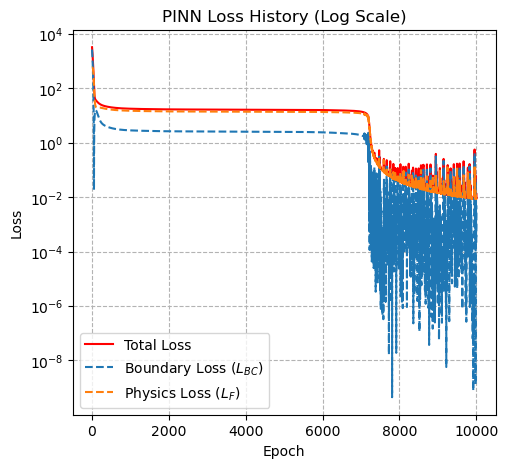

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Total Loss', color='red')
plt.plot(loss_bc_history, label='Boundary Loss ($L_{BC}$)', linestyle='--')
plt.plot(loss_f_history, label='Physics Loss ($L_F$)', linestyle='--')
plt.yscale('log')
plt.title('PINN Loss History (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.7')

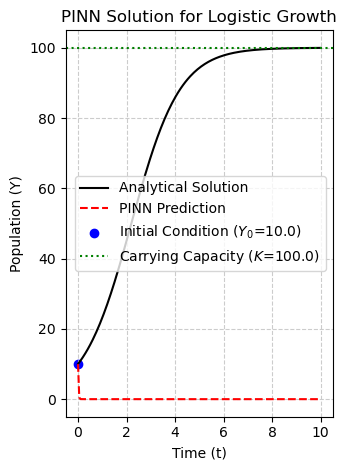

In [25]:
def analytical_solution(t, r, K, Y0):
    return K / (1 + ((K - Y0) / Y0) * np.exp(-r * t))

t_test = torch.linspace(t_min, t_max, 200, dtype=torch.float32).reshape(-1, 1).to(DEVICE)
with torch.no_grad():
    y_pred_test = model(t_test).cpu().numpy()
    
    
t_np = t_test.cpu().numpy().flatten()
y_analytical = analytical_solution(t_np, r, K, Y0)

plt.subplot(1, 2, 2)
plt.plot(t_np, y_analytical, label='Analytical Solution', color='black', linestyle='-')
plt.plot(t_np, y_pred_test, label='PINN Prediction', color='red', linestyle='--')
plt.scatter([t_min], [Y0], color='blue', label=f'Initial Condition ($Y_0$={Y0})')
plt.axhline(K, color='green', linestyle=':', label=f'Carrying Capacity ($K$={K})')
plt.title('PINN Solution for Logistic Growth')
plt.xlabel('Time (t)')
plt.ylabel('Population (Y)')
plt.legend()
plt.grid(True, ls="--", c='0.8')

plt.tight_layout()
plt.show()